In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_pinball_loss


model_df = pd.read_csv("../data/2015_2025_final.csv")
print(len(model_df))

2317


In [ ]:
#Relief Pitchers
'''
model_df = model_df[
    ((model_df["IP"] >= 30) & (model_df["GS"] <= 5))
      | 
      ((model_df["Season"] == 2020) & (model_df["IP"] >= 15) & (model_df["GS"] <= 2))
    ].copy()
'''
#Starting Pitchers
model_df = model_df[
    ((model_df["IP"] >= 80) & (model_df["GS"] >= 5))
      | 
      ((model_df["Season"] == 2020) & (model_df["IP"] >= 55))
    ].copy()
print(len(model_df))

1001


In [3]:
#IP dropped due to high correlation with GS
#fb_velo_mean dropped due to high correlation with fb_velo_max
#"pmv_original", "pmv_pc1", "gini_index" have high correlation 
features = [
    "Age", "WAR", "K%", "BB%", "HR/9", "GS", "WARt-1"
]

corr = model_df[features].corr()
print(corr)

             Age       WAR        K%       BB%      HR/9        GS    WARt-1
Age     1.000000 -0.003788 -0.057556 -0.123422  0.086503  0.083497  0.143817
WAR    -0.003788  1.000000  0.598447 -0.397401 -0.602259  0.523983  0.439057
K%     -0.057556  0.598447  1.000000 -0.087631 -0.207057  0.067872  0.374586
BB%    -0.123422 -0.397401 -0.087631  1.000000  0.070158 -0.109088 -0.201930
HR/9    0.086503 -0.602259 -0.207057  0.070158  1.000000 -0.104993 -0.160206
GS      0.083497  0.523983  0.067872 -0.109088 -0.104993  1.000000  0.202418
WARt-1  0.143817  0.439057  0.374586 -0.201930 -0.160206  0.202418  1.000000


In [ ]:
X = model_df[features].dropna()

X_scaled = (X - X.mean()) / X.std()

vif_df = pd.DataFrame({
    "feature": X_scaled.columns,
    "VIF": [
        variance_inflation_factor(X_scaled.values, i)
        for i in range(X_scaled.shape[1])
    ]
})

print(vif_df.sort_values("VIF", ascending=False))

  feature       VIF
1     WAR  7.896616
2      K%  2.649611
4    HR/9  2.590555
5      GS  2.357814
3     BB%  1.645186
6  WARt-1  1.322813
0     Age  1.063533


In [ ]:
#Conformalized Quantile Regression (CQR) for WAR(t+1)

DATA_PATH = "/Users/wilsonschwegler/Desktop/data/2015_2025_final.csv"  # <-- change if needed

TRAIN_YEARS = list(range(2015, 2017))   # train: 2015-2022
CAL_YEAR = 2017                         # calibration: 2023
TEST_YEARS = [2018]                     # test: 2024

TARGET = "WARt+1"
FEATURES = [
    "Age", "WAR", "K%", "BB%", "HR/9", "GS", "WARt-1"
]

#Quantiles for the model (keep 0.05/0.95; conformal will widen as needed)
Q_LO, Q_MED, Q_HI = 0.05, 0.50, 0.95
TARGET_ALPHA = 0.10  

#GBRT hyperparams 
TAIL_PARAMS = dict(
    learning_rate=0.03,
    n_estimators=800,
    max_depth=2,
    min_samples_leaf=20,
    min_samples_split=20,
    subsample=0.8,
    random_state=0,
)

MED_PARAMS = dict(
    learning_rate=0.03,
    n_estimators=1000,
    max_depth=3,
    min_samples_leaf=10,
    min_samples_split=10,
    subsample=0.8,
    random_state=0,
)


df = pd.read_csv(DATA_PATH)
'''
df = df[
    ((df["IP"] >= 35) & (df["GS"] <= 5))
      | 
      ((df["Season"] == 2020) & (df["IP"] >= 15) & (df["GS"] <= 2))
    ].copy()
'''
df = df[
    ((df["IP"] >= 120) & (df["GS"] >= 5))
      | 
      ((df["Season"] == 2020) & (df["IP"] >= 55))
    ].copy()


for c in FEATURES + [TARGET]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

train_df = df[df["Season"].isin(TRAIN_YEARS)].copy()
cal_df   = df[df["Season"] == CAL_YEAR].copy()
test_df  = df[df["Season"].isin(TEST_YEARS)].copy()

#drop rows missing features/target
train_df = train_df.dropna(subset=FEATURES + [TARGET])
cal_df   = cal_df.dropna(subset=FEATURES + [TARGET])
test_df  = test_df.dropna(subset=FEATURES + [TARGET])

X_train, y_train = train_df[FEATURES], train_df[TARGET].values
X_cal,   y_cal   = cal_df[FEATURES],   cal_df[TARGET].values
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET].values

print("Rows:", "train", len(train_df), "cal", len(cal_df), "test", len(test_df))

#FIT Quantile + Median Models
lo_model  = GradientBoostingRegressor(loss="quantile", alpha=Q_LO,  **TAIL_PARAMS).fit(X_train, y_train)
med_model = GradientBoostingRegressor(loss="quantile", alpha=Q_MED, **MED_PARAMS).fit(X_train, y_train)
hi_model  = GradientBoostingRegressor(loss="quantile", alpha=Q_HI,  **TAIL_PARAMS).fit(X_train, y_train)


#Conformal Calibration on CAL Set
q_lo_cal = lo_model.predict(X_cal)
q_hi_cal = hi_model.predict(X_cal)

#Asymmetric Calibration
r_lo = np.maximum(0, q_lo_cal - y_cal)   
r_hi = np.maximum(0, y_cal - q_hi_cal)   

qhat_lo = float(np.quantile(r_lo, 1 - TARGET_ALPHA/2, method="higher"))
qhat_hi = float(np.quantile(r_hi, 1 - TARGET_ALPHA/2, method="higher"))

print("Conformal widening qhat_lo:", qhat_lo)
print("Conformal widening qhat_hi:", qhat_hi)
q_lo_raw = lo_model.predict(X_test)
q_hi_raw = hi_model.predict(X_test)
#Apply asymmetric widening
q_lo_cqr = q_lo_raw - qhat_lo
q_hi_cqr = q_hi_raw + qhat_hi


def interval_metrics(y, lo, hi):
    cov = np.mean((y >= lo) & (y <= hi))
    width = np.mean(hi - lo)
    return cov, width

raw_cov, raw_width = interval_metrics(y_test, q_lo_raw, q_hi_raw)
cqr_cov, cqr_width = interval_metrics(y_test, q_lo_cqr, q_hi_cqr)

#Point metrics from median model (median predictions unchanged by conformal)
y_pred = med_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

#Pinball losses on test (raw quantiles)
pin_lo  = mean_pinball_loss(y_test, q_lo_raw, alpha=Q_LO)
pin_med = mean_pinball_loss(y_test, y_pred,   alpha=Q_MED)
pin_hi  = mean_pinball_loss(y_test, q_hi_raw, alpha=Q_HI)

#Pinball losses on test (cqr quantiles)
pin_lo_cqr  = mean_pinball_loss(y_test, q_lo_cqr, alpha=Q_LO)
pin_hi_cqr  = mean_pinball_loss(y_test, q_hi_cqr, alpha=Q_HI)

print("\n=== TEST RESULTS (point) ===")
print("MAE :", mae)

print("\n=== TEST RESULTS (pinball, raw quantiles) ===")
print(f"q{Q_LO:.2f}:", pin_lo)
print(f"q{Q_MED:.2f}:", pin_med)
print(f"q{Q_HI:.2f}:", pin_hi)

print("\n=== TEST RESULTS (pinball, cqr quantiles) ===")
print(f"q{Q_LO:.2f}:", pin_lo_cqr)
print(f"q{Q_MED:.2f}:", pin_med)
print(f"q{Q_HI:.2f}:", pin_hi_cqr)

print("\n=== TEST RESULTS (intervals) ===")
print(f"RAW  interval (q{Q_LO:.2f}–q{Q_HI:.2f}) coverage:", raw_cov, "avg width:", raw_width)
print(f"CQR  interval (conformalized)      coverage:", cqr_cov, "avg width:", cqr_width)

def winkler_score(y, lo, hi, alpha):
    width = hi - lo
    penalty_lo = np.maximum(0, lo - y)
    penalty_hi = np.maximum(0, y - hi)
    penalty = (2 / alpha) * (penalty_lo + penalty_hi)
    return np.mean(width + penalty)
winkler_raw = winkler_score(y_test, q_lo_raw, q_hi_raw, TARGET_ALPHA)
winkler_cqr = winkler_score(y_test, q_lo_cqr, q_hi_cqr, TARGET_ALPHA)
print("\n=== Winkler scores (lower is better) ===")
print("RAW :", winkler_raw)
print("CQR :", winkler_cqr)


pred_df = (
    test_df[["IDfg","Name","Season"]].copy()
    if all(c in test_df.columns for c in ["IDfg","Name","Season"])
    else test_df[["Season"]].copy()
)
pred_df["y_true"] = y_test
pred_df[f"q{Q_LO:.2f}_raw"] = q_lo_raw
pred_df[f"q{Q_HI:.2f}_raw"] = q_hi_raw
pred_df[f"q{Q_LO:.2f}_cqr"] = q_lo_cqr
pred_df[f"q{Q_HI:.2f}_cqr"] = q_hi_cqr
pred_df["q0.50"] = y_pred

Rows: train 102 cal 93 test 102
Conformal widening qhat_lo: 0.8780100118583928
Conformal widening qhat_hi: 1.7656563738040916

=== TEST RESULTS (point) ===
MAE : 1.5673984157417278
RMSE: 3.633821844396898

=== TEST RESULTS (pinball, raw quantiles) ===
q0.05: 0.14860011174701088
q0.50: 0.7836992078708639
q0.95: 0.25472166194744045

=== TEST RESULTS (intervals) ===
RAW  interval (q0.05–q0.95) coverage: 0.7156862745098039 avg width: 3.4981007529730705
CQR  interval (conformalized)      coverage: 0.9607843137254902 avg width: 6.1417671386355535

=== Winkler scores (lower is better) ===
RAW : 8.066435473889026
CQR : 6.942929083226094


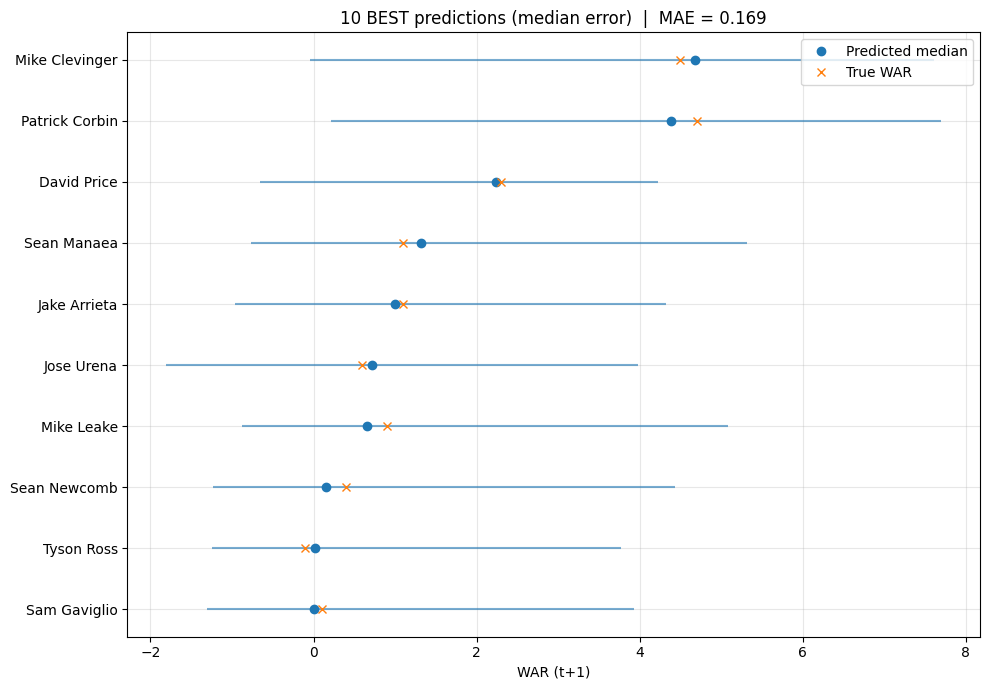

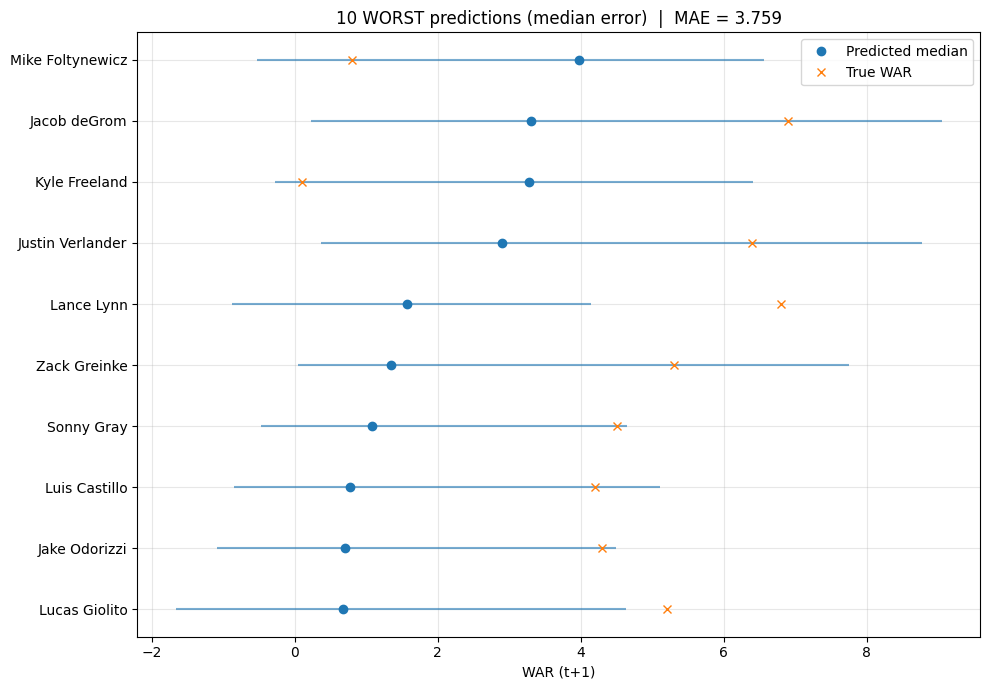

In [ ]:
def plot_intervals(df, title):
    df = df.sort_values("q0.50").copy()
    y = np.arange(len(df))

    #MAE for the subset being plotted
    mae = np.mean(np.abs(df["y_true"] - df["q0.50"]))

    plt.figure(figsize=(10, 7))
    plt.hlines(
        y=y,
        xmin=df[f"q{Q_LO:.2f}_cqr"],
        xmax=df[f"q{Q_HI:.2f}_cqr"],
        alpha=0.6
    )
    plt.plot(df["q0.50"], y, "o", label="Predicted median")
    plt.plot(df["y_true"], y, "x", label="True WAR")

    plt.yticks(y, df["Name"] if "Name" in df.columns else df.index)
    plt.xlabel("WAR (t+1)")
    plt.title(f"{title}  |  MAE = {mae:.3f}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

viz_df = pred_df.copy()
viz_df["abs_error"] = np.abs(viz_df["y_true"] - viz_df["q0.50"])

best10  = viz_df.nsmallest(10, "abs_error")
worst10 = viz_df.nlargest(10, "abs_error")

plot_intervals(best10,  "10 BEST predictions (median error)")
plot_intervals(worst10, "10 WORST predictions (median error)")


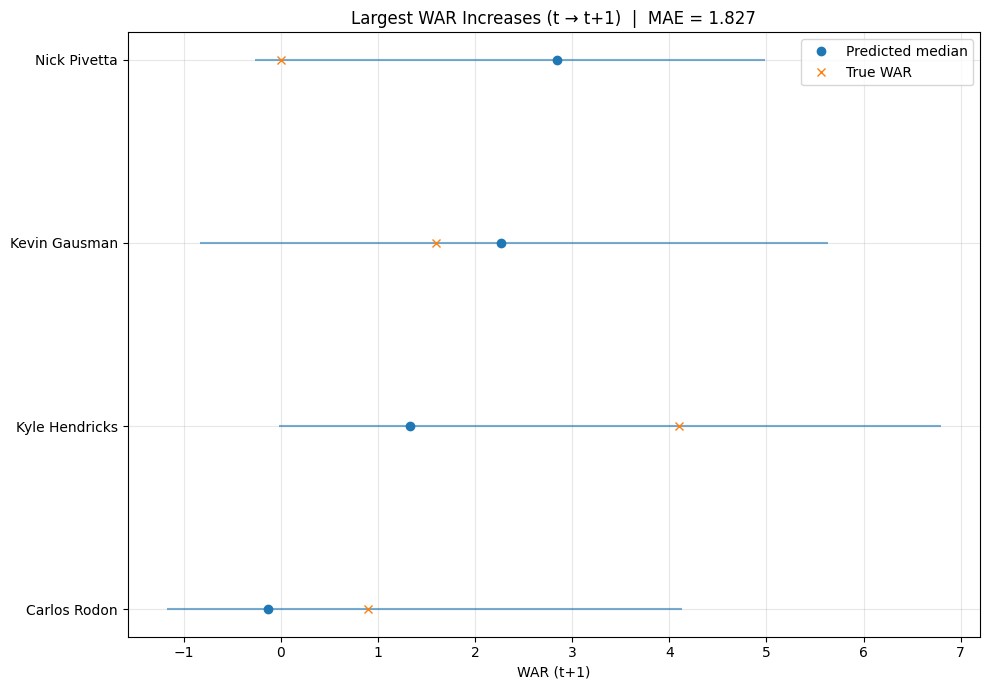

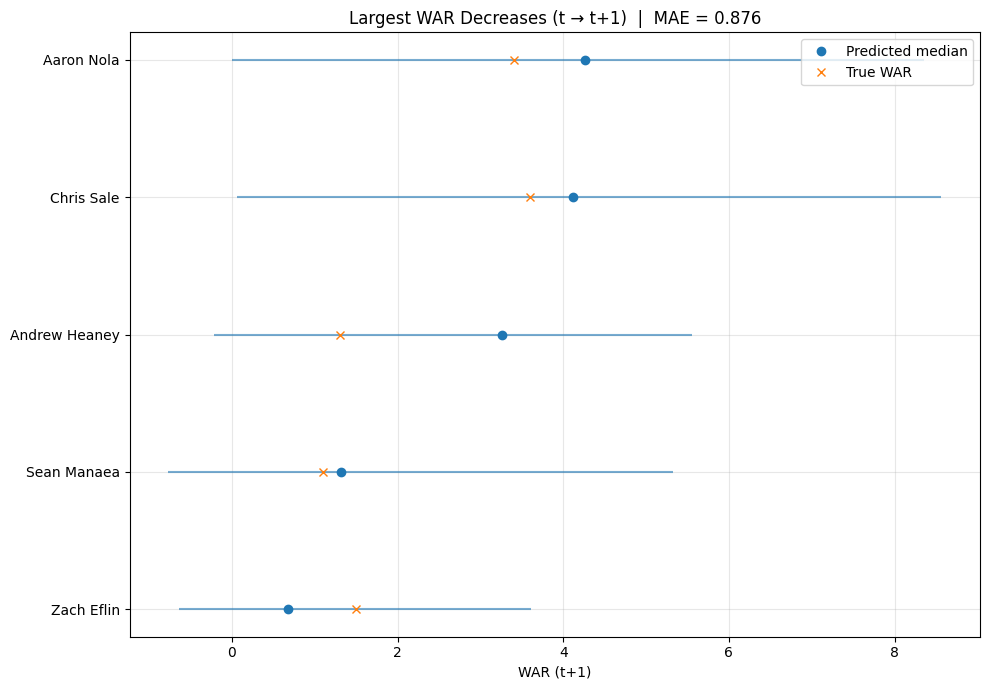

In [ ]:
#Largest WAR Changes
df_diff = df = df[df["Season"] == 2024].copy()
df_diff["WAR_diff"] = df_diff["WARt+1"] - df_diff["WAR"]

top_5_positive = (
    df_diff
    .dropna(subset=["WAR", "WARt+1"])
    .nlargest(20, "WAR_diff")
)

top_5_negative = (
    df_diff
    .dropna(subset=["WAR", "WARt+1"])
    .nsmallest(20, "WAR_diff")
)

best_names = top_5_positive["Name"].tolist()
worst_names = top_5_negative["Name"].tolist()

Best = viz_df[viz_df["Name"].isin(best_names)]
Worst = viz_df[viz_df["Name"].isin(worst_names)]

plot_intervals(Best,  "Largest WAR Increases (t → t+1)")
plot_intervals(Worst, "Largest WAR Decreases (t → t+1)")